Nous allons à travers ce notebook mettre en place une application dont le but sera en donnant un simple produit et le pays de trouver un équivalent avec un meilleur nutriscore en fonction du pays.

In [39]:
%matplotlib inline
import re
import pandas as pd 
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

 

data = pd.read_csv("data/data_imputer.csv", "\t")

def get_all_numeric_col(data):
    all_numeric_col=[]
    all_type_nume=["float64","int64"]
    for col in list(data.columns):
        dtype = str(data[col].dtypes)
        if dtype in all_type_nume:
            all_numeric_col.append(col)
    return all_numeric_col

quantitative = get_all_numeric_col(data)
quantitative_exclude_energy = quantitative.copy()
quantitative_exclude_energy.remove("energy_100g")
quantitative_exclude_energy.remove("energy-kcal_100g")

C:\Users\dfzra\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3251: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


# Analyse univariée

Nous allons faire une analyse univariée afin de déterminer les différences possibles d'apport en protéines, sucre et graissons des produits en fonction de leur catégorie


In [40]:
data.head()

data = data[["energy-kcal_100g", 
              "energy_100g", 
              "fat_100g", 
              "saturated-fat_100g", 
              "carbohydrates_100g", 
              "sugars_100g", 
              "proteins_100g", 
              "salt_100g", 
              "nutrition-score-fr_100g",
              "product_name",
              "pnns_groups_1",
              "pnns_groups_2",
              "nutriscore_grade"]]

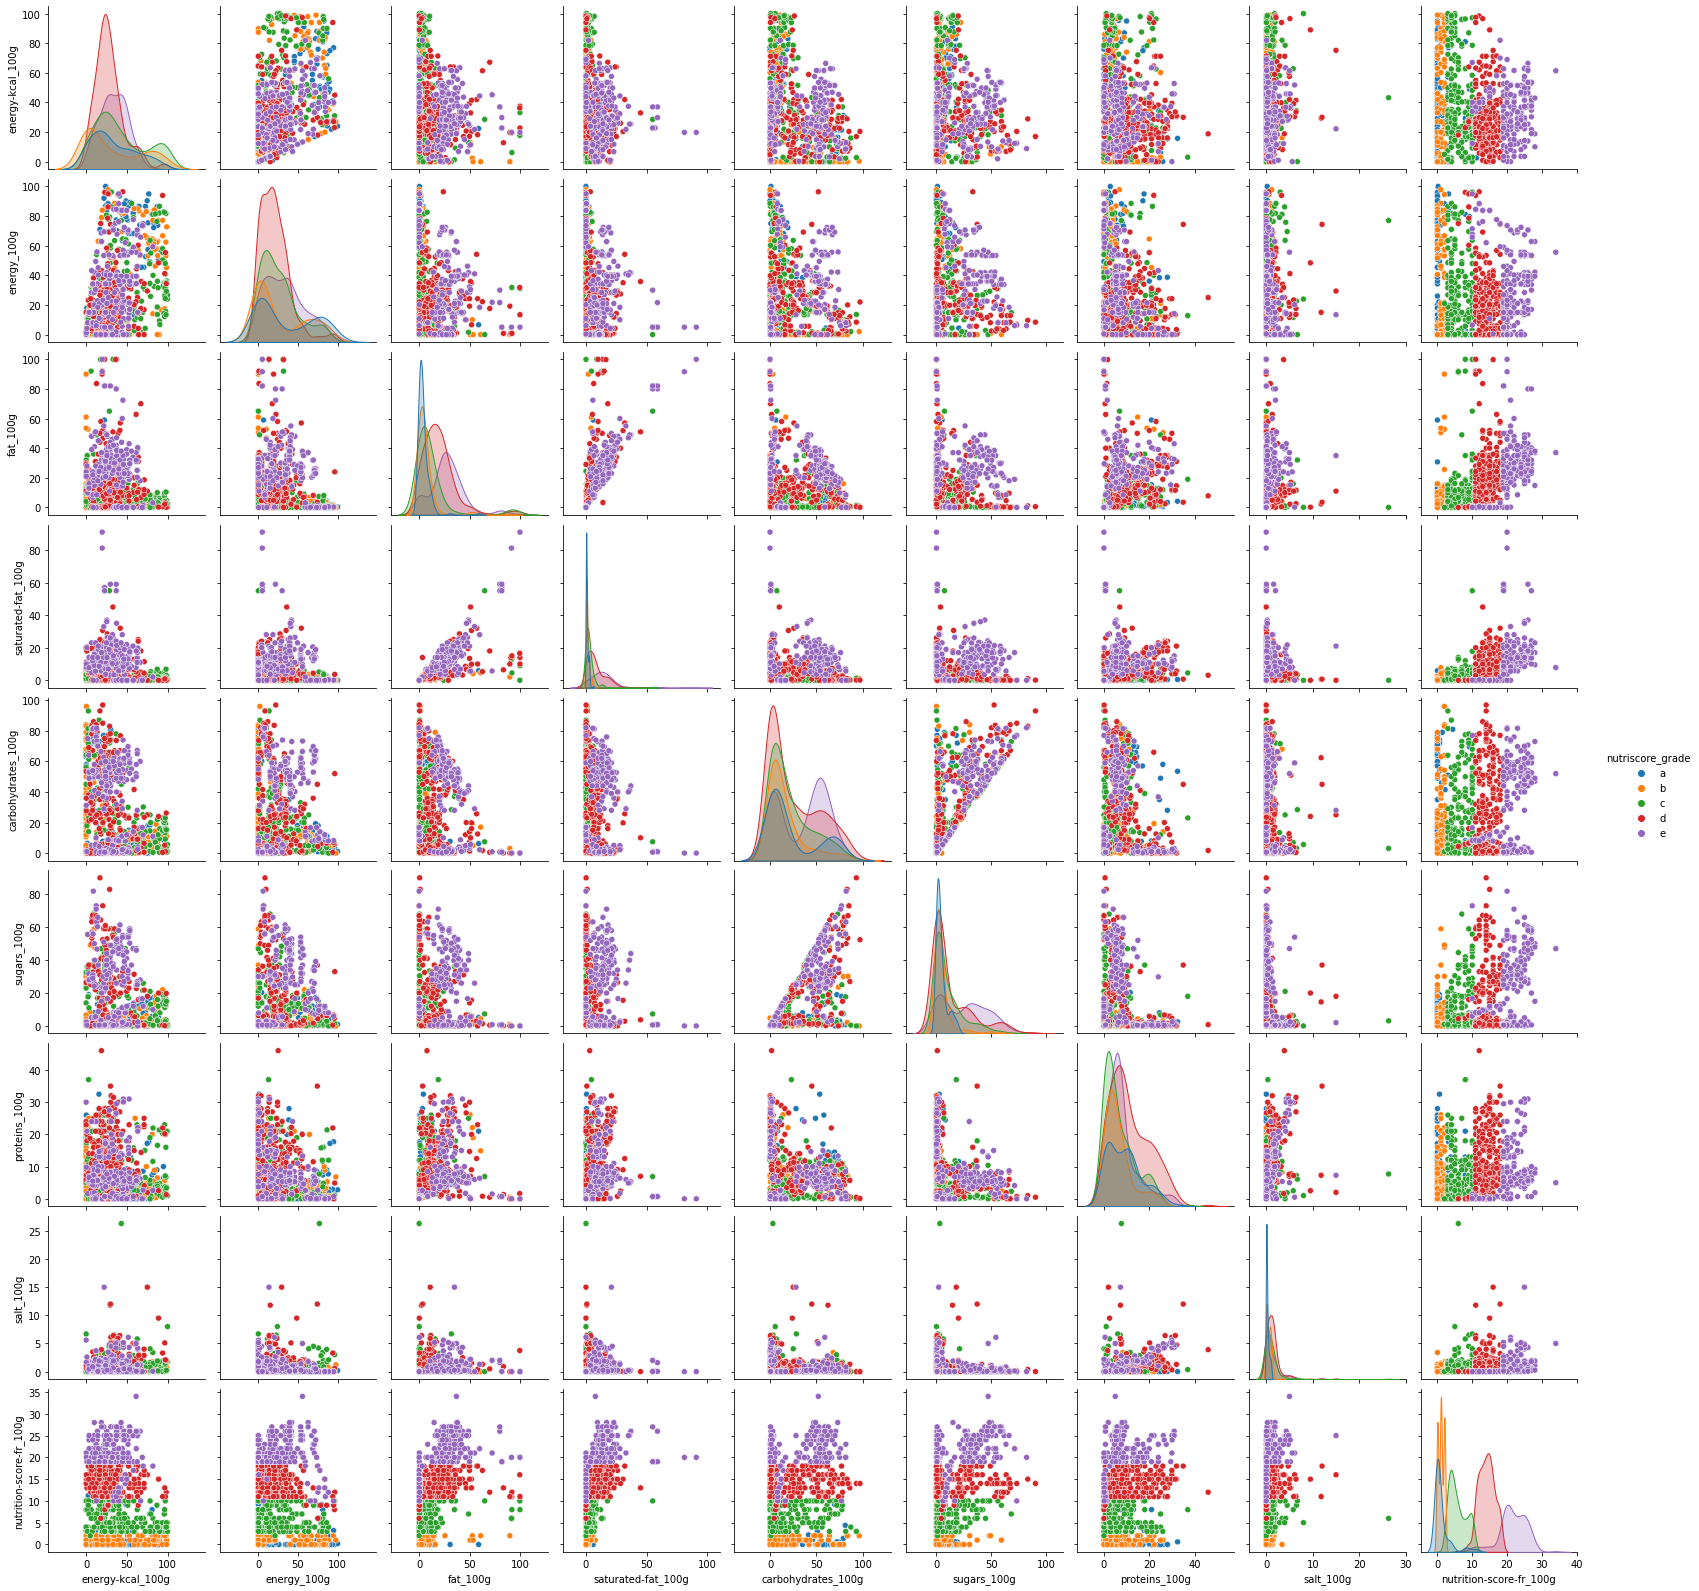

In [41]:
ax= sns.pairplot(data.sample(1000, random_state=0).sort_values(by="nutriscore_grade"), hue="nutriscore_grade")
plt.show()

Après analyse des colonnes une par une, il est presque impossible d'avoir une idée sur les hypothèses suivantes : 

- L'impression que plus le rang nutrionnel augmente et plus le sucre, le sel et le gras augmente et de même pour les protéines, fibre et glucides.

- Le sucre et glucide sont de la même famille tout comme le gras et le gras saturée

- L'energie semble être déterminé par le sucre, glucide, gras et gras saturée.

Pour essayer de mieux d'affirmer cette hypothèse, nous allons faire une PCA (Analyse en composant principale) qui permettra de faire sortir les informations clés du dataset 

Text(0.5, 1.0, 'Eboulis des valeurs propres.')

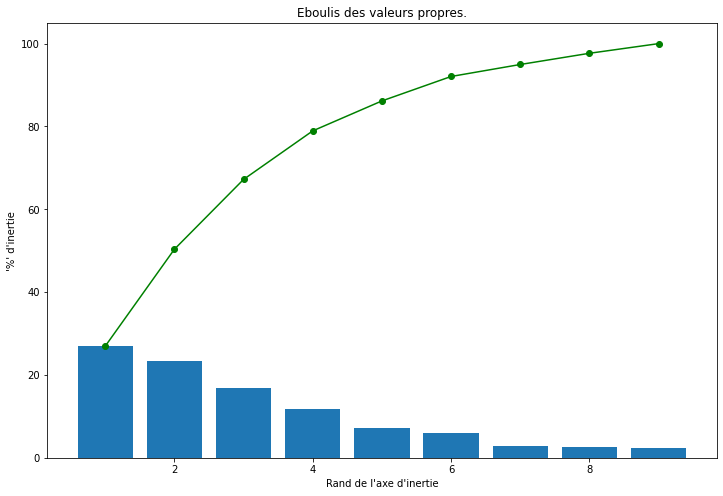

In [46]:
from sklearn.decomposition import PCA

X = data.select_dtypes(include=['float64','int64'])
X_scaled = scaler.fit_transform(X)

pca = PCA(svd_solver='full').fit(X_scaled)
X_projected = pca.transform(X_scaled) 

var_expl = pca.explained_variance_ratio_*100

plt.figure(figsize=(12,8))
plt.bar(np.arange(len(var_expl))+1, var_expl)
plt.plot(np.arange(len(var_expl))+1, var_expl.cumsum(),c="green",marker='o')
plt.xlabel("Rand de l'axe d'inertie")
plt.ylabel("'%' d'inertie")
plt.title("Eboulis des valeurs propres.")

In [47]:
print("Inertie de F1 : {:.2f}% et intertie du second plan : {:.2f}%.".format(var_expl[0:2].sum(),
                                                                                                     var_expl[0:4].sum()))

Inertie de F1 : 50.34% et intertie du second plan : 78.93%.


Les 2 premiers plans factoriels couvrent une inertie d'un peu plus de 77%. Une analyse sur F1 et F2 tout à fait  cohérente.

Cercle des corrélations :

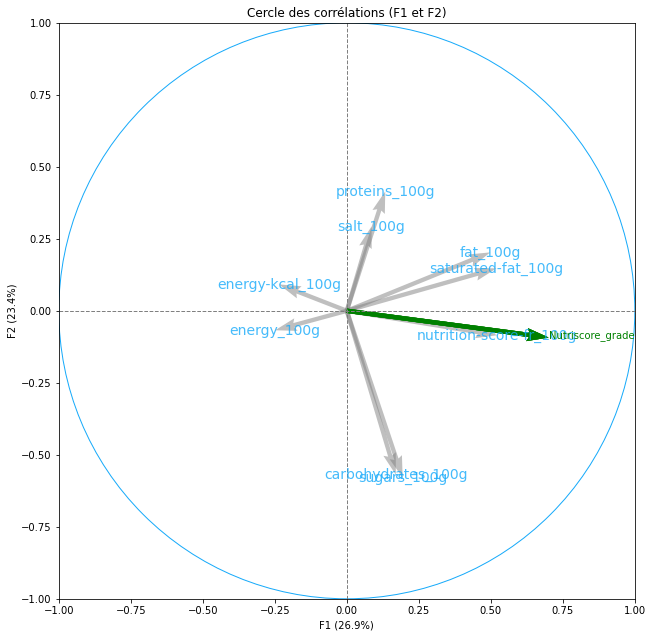

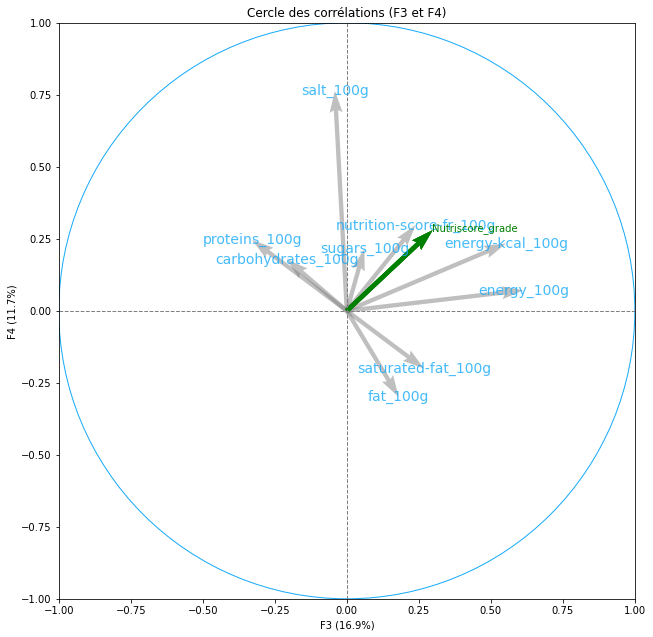

In [49]:
from sklearn.preprocessing import LabelEncoder

ivNutrigrade = data['nutriscore_grade'].values

encoder = LabelEncoder()
ivNutrigrade = encoder.fit_transform(ivNutrigrade)
ivNutrigrade = ivNutrigrade.reshape((ivNutrigrade.shape[0],1))

corr_Iv = np.zeros((ivNutrigrade.shape[1],p))
for j in range(p): 
    for k in range(ivNutrigrade.shape[1]): 
        corr_Iv[k,j] = np.corrcoef(ivNutrigrade[:,k],X_projected[:,j])[0,1] 

def cerle_corr(pcs, n_comp, pca, axis_ranks, 
               labels=None, label_rotation=0, 
               illustrative_var_label=None, illustrative_var_corr=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            
            # initialisation de la figure
            fig=plt.figure(figsize=(10,10))
            fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax=fig.add_subplot(111)
            ax.set_aspect('equal', adjustable='box') 

            #détermination des limites du graphique
            ax.set_xlim(-1,1) 
            ax.set_ylim(-1,1) 

            #affichage des flèches 
            plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                       pcs[d1,:],pcs[d2,:], 
                       angles='xy', scale_units='xy', scale=1, 
                       color="grey", alpha=0.5)
            # et noms de variables
            for i,(x,y) in enumerate(pcs[[d1,d2]].T):
                plt.annotate(labels[i],(x,y),
                             ha='center', va='center',
                             fontsize='14',color="#17aafa", alpha=0.8) 

            #variable illustrative
            if illustrative_var_label is not None :
                plt.annotate(illustrative_var_label,
                             (illustrative_var_corr[0,d1],illustrative_var_corr[0,d2]),
                             color='g')
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                                   illustrative_var_corr[0,d1],illustrative_var_corr[0,d2], 
                                   angles='xy', scale_units='xy', scale=1, color="g", alpha=0.5)

            #ajouter les axes 
            plt.plot([-1,1],[0,0],linewidth=1, color='grey', ls='--') 
            plt.plot([0,0],[-1,1],linewidth=1, color='grey', ls='--')

            #ajouter un cercle 
            cercle = plt.Circle((0,0),1,color='#17aafa',fill=False) 
            ax.add_artist(cercle) 

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

cerle_corr(pcs, 4, pca, [(0,1),(2,3)], labels = np.array(X.columns), 
           illustrative_var_label="Nutriscore_grade", illustrative_var_corr = corrIv)



Pour F1, on remarque la corrélation avec le gras, gras saturée, sucre et glucide impactent l'énergie et on peut donc affirmer que cela entraîne une augmentation du rang de nutriscore.
Par contre pour F4, on remarque l'inverse, qui sera plus corrélée avec les protéines 

On peut également déduire grâce à F3 et F4 que le rang A possède beaucoup plus de protéines et de glucide ainsi que moins de graisse et de sucre que les autres rangs